In [1]:
# https://siboehm.com/articles/19/normalizing-flow-network
# https://github.com/karpathy/pytorch-normalizing-flows
# https://arxiv.org/pdf/1908.09257.pdf
# https://raw.githubusercontent.com/abdulfatir/normalizing-flows/master/report/report.pdf
# https://siboehm.com/assets/img/nfn/Bachelorarbeit_Simon_Boehm.pdf
# https://github.com/e-hulten/planar-flows/blob/master/planar_transform.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import datasets

### Normalizing Flows (2D)

We know that we can apply transformations with certain contraints (differentiable and invertible) to a know distribution and get new distributions from which we can sample and compute its likelihood. In this notebook we will explore some of this functions known as Normalizing Flows (NF).

We will with the following synthetic dataset

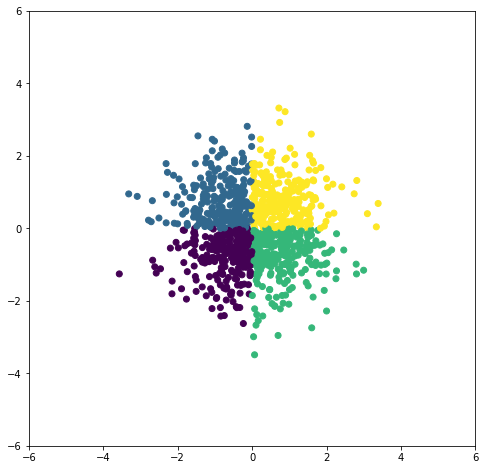

In [320]:
dataMean = np.array([0, 0])
dataCov = [[1, 0], [0, 1]]

X = np.random.multivariate_normal(mean = dataMean, cov = dataCov, 
                                  size = 1000)
def annotate(x):
    if(x[0] < 0 and x[1] < 0):
        return 1
    elif(x[0] < 0 and x[1] > 0):
        return 2
    elif(x[0] > 0 and x[1] < 0):
        return 3
    else:
        return 4
    
Y = [annotate(x) for x in X]

plt.figure(figsize = (8,8))
plt.scatter(X[:,0], X[:,1], c = Y)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

#### Affine Flows

This flow performs a scale and shift operation over a Gaussian so we still get a Gaussian

$\textbf{a}, \textbf{b} \in \mathbb{R}^{d} \quad f(\textbf{x})=e^{\textbf{a}} \odot \textbf{x} + \textbf{b} \quad f^{-1}(\textbf{z})=(\textbf{z} - \textbf{b}) \odot e^{-\textbf{a}}$

In [321]:
class AffineFlow:
    
    def __init__(self, X, a, b,
                 dataMean = dataMean, dataCov = dataCov):
        self.X = X
        self.a = a
        self.b = b
        
    def forward(self):
        self.Z = np.exp(self.a) * self.X + self.b
        
    def backward(self):
        self.X_rec = (self.Z - self.b) * np.exp(-self.a)
        
    def sample_Z(self, value):
        return np.exp(self.a) * value + self.b
    
    def recover_X(self, value):
        return (value - self.b) * np.exp(-self.a)
    
    def prob_X(self, value):
        return round(stats.multivariate_normal.pdf(value,
                                                   mean = dataMean, cov = dataCov), 3)
    
    def prob_Z(self, value):
        return round(self.prob_X(self.recover_X(value)) * np.exp(-np.sum(a)), 3)

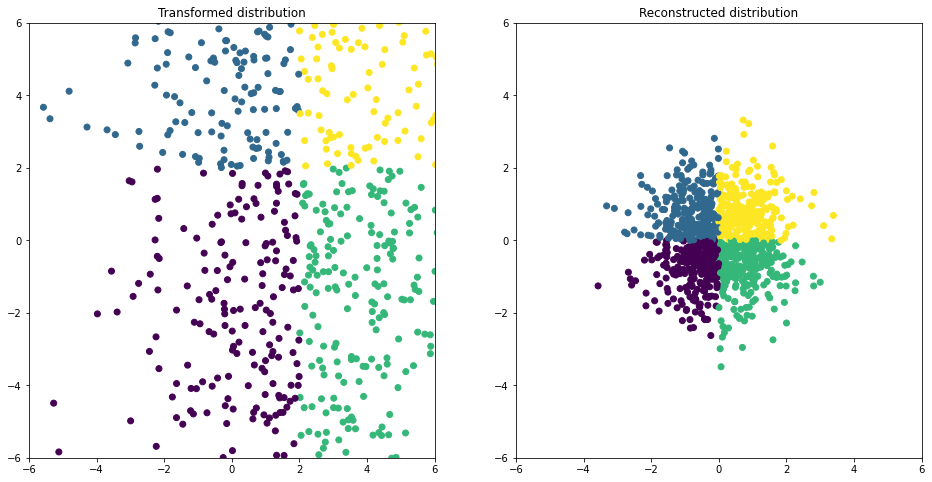

In [329]:
a = np.array([1, 2])
b = np.array([2, 2])

flow = AffineFlow(X = X, a = a, b = b)
flow.forward()
flow.backward()

fig, axs = plt.subplots(1, 2, figsize = (16, 8))
axs[0].scatter(flow.Z[:,0], flow.Z[:,1], c = Y)
axs[1].scatter(flow.X_rec[:,0], flow.X_rec[:,1], c = Y)

axs[0].set_xlim(-6, 6)
axs[0].set_ylim(-6, 6)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(-6, 6)

axs[0].title.set_text('Transformed distribution')
axs[1].title.set_text('Reconstructed distribution')

plt.show()

We can sample from the new distribution using a sample from the prior:

In [330]:
flow.sample_Z([0, 0])

array([2., 2.])

We can recover the X given this sample:

In [331]:
flow.recover_X([2, 2])

array([0., 0.])

And compute the probability of a sample of Z:

In [332]:
flow.prob_Z([0, 0])

0.006

In [333]:
flow.prob_X([0, 0])

0.159

#### Planar Flows

$\textbf{w}, \textbf{u} \in \mathbb{R}^{d}, \textbf{b} \in \mathbb{R} \quad
f({\textbf{x}})=\textbf{x}+\textbf{u} \, \mathrm{tanh}(\textbf{w}^{T}\textbf{z}+b)$

In [377]:
class PlanarFlow:
    
    def __init__(self, X, w, u, b,
                 dataMean = dataMean, dataCov = dataCov):
        self.X = X
        self.w = w
        self.u = u
        self.b = b
        
    def forward(self):
        self.Z = self.X + self.u * np.tanh(np.transpose(self.w) * self.X + self.b)
        
    def backward(self):
        return 'Not implemented'
        
    def sample_Z(self, value):
        return value + self.u * np.tanh(np.transpose(self.w) * value + self.b)
    
    def recover_X(self, value):
        return 'Not implemented'
    
    def prob_X(self, value):
        return round(stats.multivariate_normal.pdf(value,
                                                   mean = dataMean, cov = dataCov), 3)
    
    def prob_Z(self, valueX):
        
        valueZ = self.sample_Z(valueX)
        print('Sampled Z value: {}'.format(valueZ))
        log_det = -np.log(np.abs(np.transpose(self.u) * \
                          np.arctanh(np.transpose(self.w) * valueZ + self.b) * self.w))
        return self.prob_X(valueX) * np.exp(log_det)

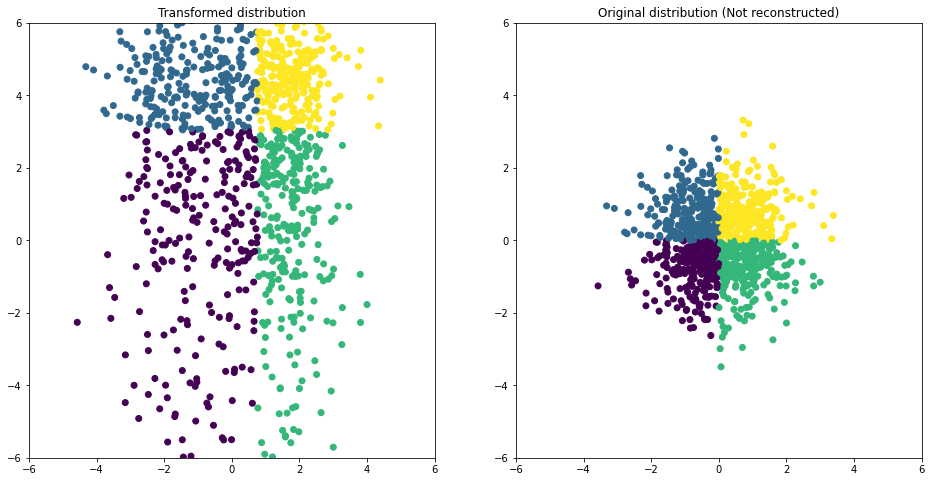

In [384]:
w = np.array([2, 1])
u = np.array([1, 4])
b = 1

flow = PlanarFlow(X = X, w = w, u = u, b = b)
flow.forward()

fig, axs = plt.subplots(1, 2, figsize = (16, 8))
axs[0].scatter(flow.Z[:,0], flow.Z[:,1], c = Y)
axs[1].scatter(X[:,0], X[:,1], c = Y)

axs[0].set_xlim(-6, 6)
axs[0].set_ylim(-6, 6)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(-6, 6)

axs[0].title.set_text('Transformed distribution')
axs[1].title.set_text('Original distribution (Not reconstructed)')

plt.show()

We can sample from the new distribution using a sample from the prior:

In [385]:
flow.sample_Z([0, 0])

array([0.76159416, 3.04637662])

And compute the probability of a sample of Z:

In [386]:
flow.prob_Z([0, 0])

Sampled Z value: [0.76159416 3.04637662]


<ipython-input-377-a71d2225c2bc>:30: RuntimeWarning: invalid value encountered in arctanh
  np.arctanh(np.transpose(self.w) * valueZ + self.b) * self.w))


array([nan, nan])